# Find genome-wide significant loci
- Inspired from: https://github.com/Nealelab/UK_Biobank_GWAS/blob/master/imputed-v2-gwas/Manhattan_plot.R
- does not work well with pan-UKBB


In [1]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [2]:
dir.create("pipeline/eqtls.0.1.coloc_gwas"     , showWarnings = FALSE)
dir.create("pipeline/eqtls.0.1.coloc_gwas/loci", showWarnings = FALSE)


# Filter manifest

In [3]:
infiles               = list.files("pipeline/1.1.sumstats/sumstats", pattern = "bgz$")
manifest              = fread("input/sumstats_manifest.txt", sep = "\t", header = TRUE, data.table = FALSE)
manifest              = manifest[ manifest$filename %in% infiles,]
manifest$sumstat_file = paste(getwd(), "pipeline", "1.1.sumstats", "sumstats", manifest$filename, sep = "/")
manifest$id           = sub(".tsv.bgz", "", manifest$filename)
rownames(manifest)    = manifest$id

manifest   = manifest[c("continuous-102-both_sexes-irnt", "continuous-12340-both_sexes-irnt", "continuous-PP-both_sexes-combined_medadj_irnt", "icd10-I48-both_sexes", "phecode-411.2-both_sexes") , ]


In [4]:
populations = c('AFR','AMR','CSA','EAS','EUR','MID')

In [5]:
manifest$name = unlist(lapply(manifest$description, function(x){unlist(strsplit(x, ","))[[1]]}))
manifest[ manifest$description == "Treatment/medication code", "name"] = manifest[ manifest$description == "Treatment/medication code", "coding_description"]
manifest[ manifest$phenocode   == "LDLC"                     , "name"] = "LDL adjusted by medication"
manifest[ manifest$id          == "icd10-I48-both_sexes"     , "name"] = "Atrial fibrillation"


In [6]:
manifest$n_cases_meta    = rowSums(manifest[, paste("n_cases"   , populations, sep = "_")], na.rm = TRUE)
manifest$n_controls_meta = rowSums(manifest[, paste("n_controls", populations, sep = "_")], na.rm = TRUE)


In [7]:
manifest$color = sequential_hcl(n = nrow(manifest), palette = "Batlow")
fwrite(manifest, "pipeline/eqtls.0.1.coloc_gwas/manifest.txt", sep = "\t", col.names = TRUE, row.names = TRUE)

# For each GWAS, get all variants with p-value <= 5e-8

In [8]:
get_loci = function(id, manifest, populations)
{
    message(id, appendLF = FALSE)
    
    infile        = manifest[id, "sumstat_file"]
    indata        = fread(cmd = paste("zcat", infile), sep = "\t", header = TRUE, data.table = FALSE)
    out           = indata
    out           = out[ is.na(out$pval_meta) == FALSE & out$pval_meta <= 5e-8 & out$pval_heterogeneity >= 1e-6, c("chr", "pos", "ref", "alt", "pval_meta")]
    colnames(out) = c("chrom", "pos", "ref", "alt", "pval")
    out$id        = paste(out$chrom, out$pos, out$ref, out$alt, sep = "_")
    rownames(out) = out$id
    
    fwrite(out[order(out$chrom, out$pos), c("chrom", "pos", "pos", "id")], paste0("pipeline/eqtls.0.1.coloc_gwas/loci/", id, ".bed"), sep = "\t", col.names = FALSE, row.names = FALSE)
    
    return(out)
}

totest          = manifest$id
populations     = c('AFR','AMR','CSA','EAS','EUR','MID')
var_list        = lapply(totest, function(id){get_loci(id, manifest, populations)})
names(var_list) = totest

saveRDS(var_list, "pipeline/eqtls.0.1.coloc_gwas/loci/var_list.rds")


continuous-102-both_sexes-irnt
continuous-12340-both_sexes-irnt
continuous-PP-both_sexes-combined_medadj_irnt
icd10-I48-both_sexes
phecode-411.2-both_sexes


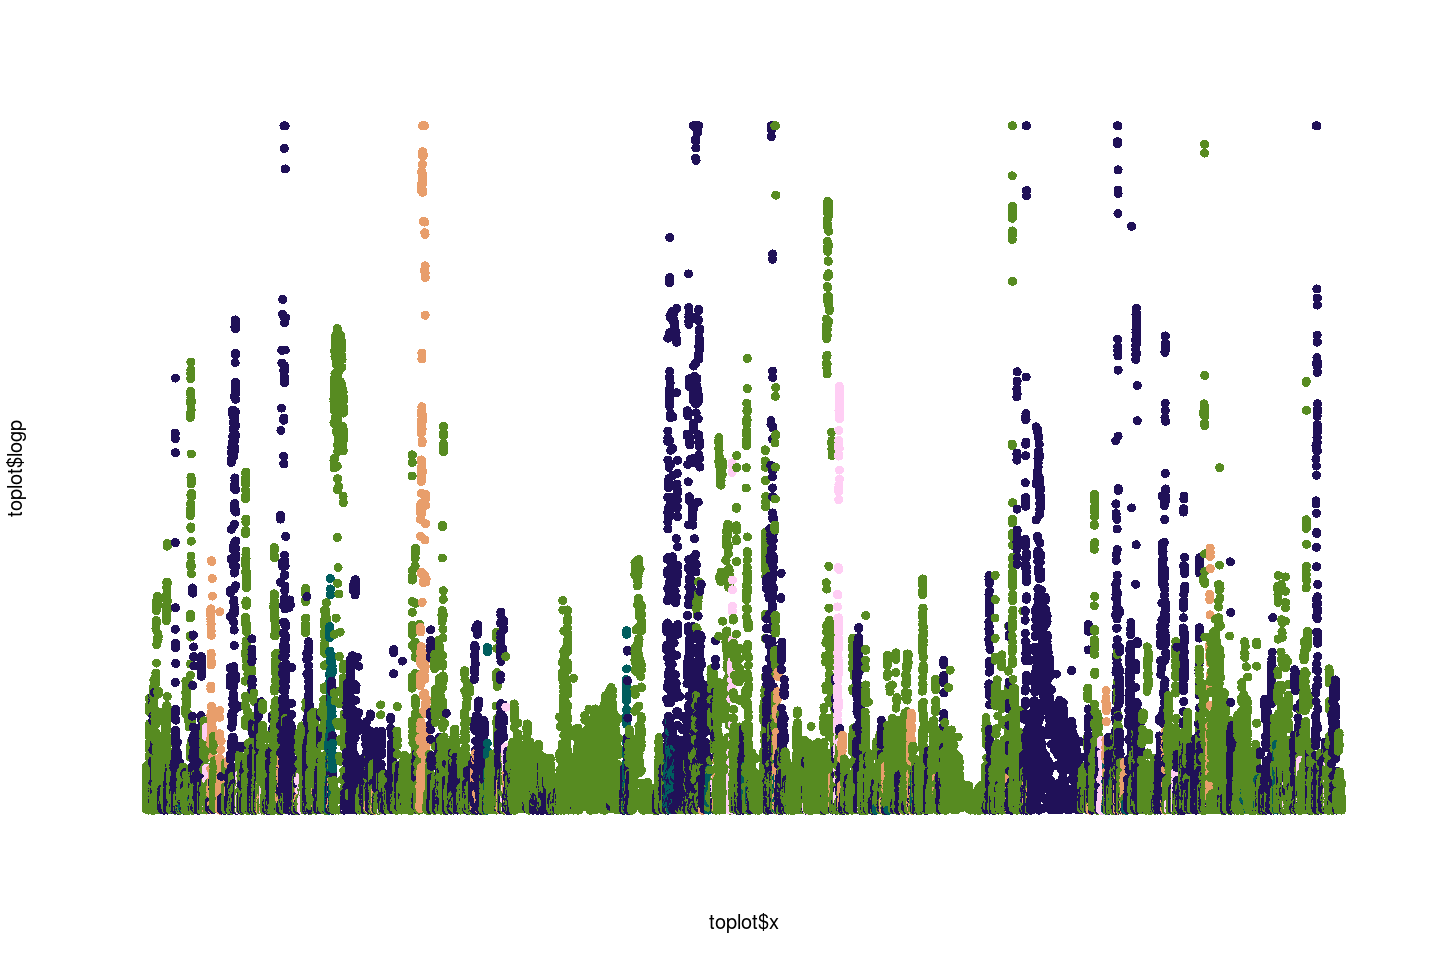

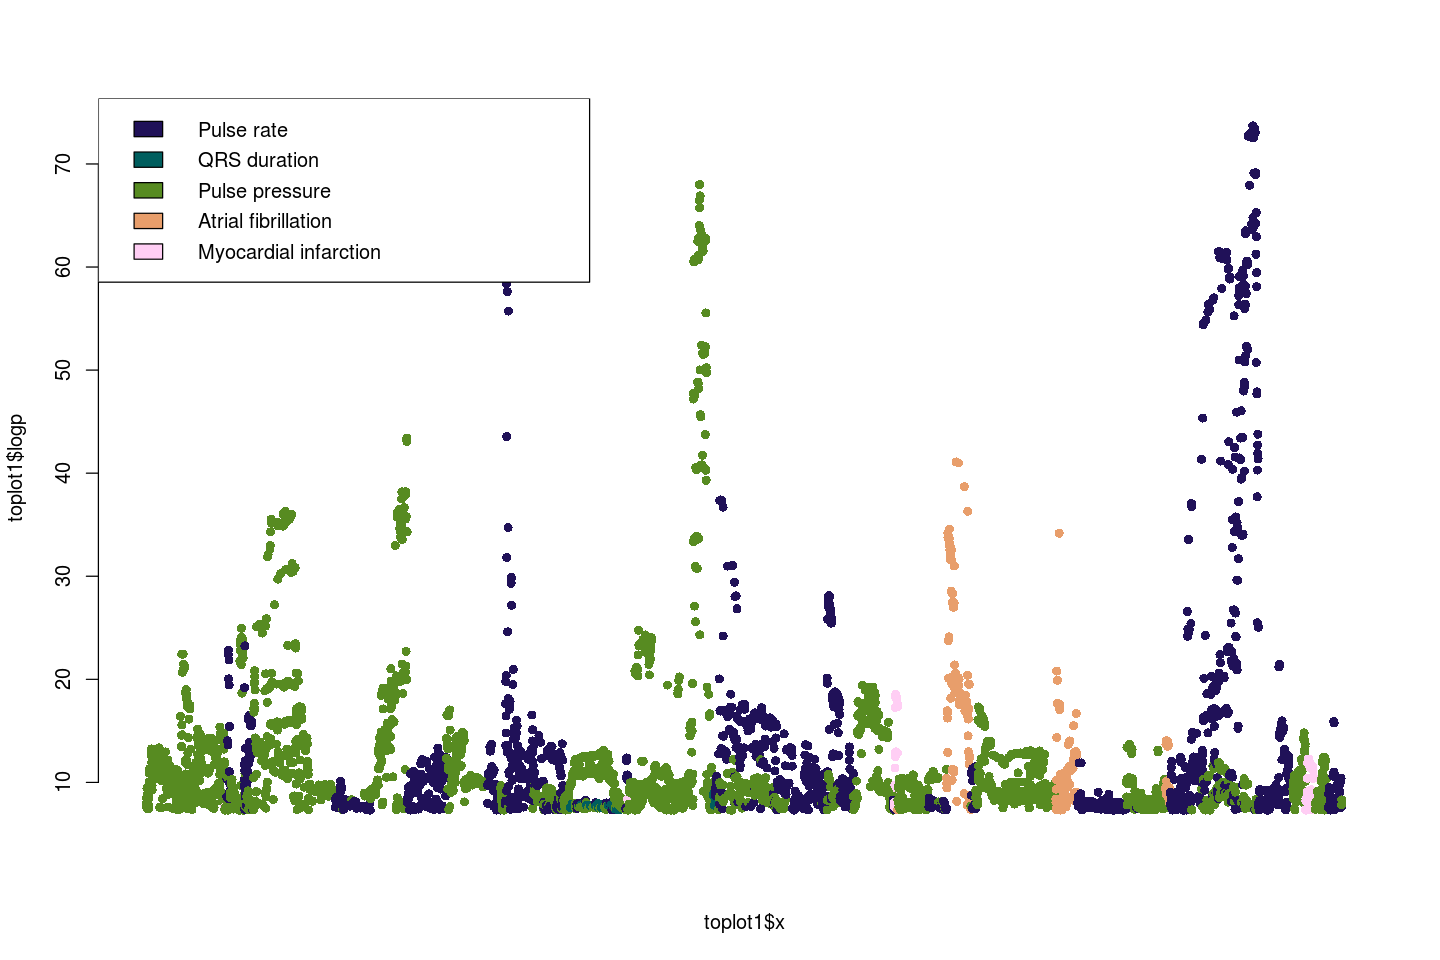

In [9]:
plot_manhattan = function(manifest2color, var_list)
{
    toplot = as.data.frame(rbindlist(lapply(manifest2color$id, function(trait)
    {
        x       = var_list[[trait]]
        x       = x[is.na(x$pval) == FALSE,]
        x$id    = trait
        x$color = manifest2color[trait, "color"]
        
        return(x)
    })), stringsAsFactors = FALSE)
    
    toplot[ toplot$pval < 1e-100, "pval"] = 1e-100
    
    toplot$logp = -log10(toplot$pval)
    mypos       = unique(toplot[order(toplot$chrom, toplot$pos), c("chrom", "pos")])
    mypos$x     = 1:nrow(mypos)
    toplot      = merge(toplot, mypos, by = c("chrom", "pos"))
    toplot      = toplot[order(toplot$x, toplot$logp),]
    
    #plot(toplot$x, toplot$logp, pch = 16, col = toplot$color, axes = FALSE, xlim = c(0,1000))
    #plot(toplot$x, toplot$logp, pch = 16, col = toplot$color, axes = FALSE, xlim = c(0,10000))
    plot(toplot$x, toplot$logp, pch = 16, col = toplot$color, axes = FALSE)
    
    toplot1 = toplot[toplot$chrom == 1,]
    
    plot(toplot1$x, toplot1$logp, pch = 16, col = toplot1$color, axes = FALSE)
    axis(2)
    abline(h = 0)
    
    legend("topleft", legend = manifest$name, fill = manifest$color)

    return(toplot)
}

options(repr.plot.width = 12, repr.plot.height = 8)
toplot = plot_manhattan(manifest, var_list)


## data for Manhattan plots
- all genome wide significant
- random points that are not genome wide significant

In [10]:
chromsizes           = fread("/frazer01/reference/public/hg19/hg19.size.txt", sep = "\t", header = FALSE, data.table = FALSE)
colnames(chromsizes) = c("chrom", "size")
chromsizes$chrom     = sub("chr", "", chromsizes$chrom)
chromsizes           = chromsizes[ chromsizes$chrom %in% as.character(1:22),]
chromsizes$chrom     = as.numeric(chromsizes$chrom)
chromsizes$x0        = c(0, unlist(lapply(1:(nrow(chromsizes) - 1), function(ii){sum(chromsizes[1:ii, "size"])})))

In [11]:
get_manhattan_plot = function(id, manifest, chromsizes)
{
    message(id, appendLF = FALSE)
    infile        = manifest[id, "sumstat_file"]
    indata        = fread(cmd = paste("zcat", infile), sep = "\t", header = TRUE, data.table = FALSE)
    out           = indata[is.na(indata$pval_meta) == FALSE & indata$pval_heterogeneity >= 1e-6, c("chr", "pos", "ref", "alt", "pval_meta")]
    out1          = out[ out$pval_meta <= 1e-5 , ]
    out2          = out[ out$pval_meta > 1e-5 , ]
    out2          = out2[sample(x = 1:nrow(out2), size = 100000, replace = FALSE),]
    out           = merge(rbind(out1, out2), chromsizes[,c("chrom", "x0")], by.x = "chr", by.y = "chrom")
    out$x         = out$x0 + out$pos
    out$logp      = -log10(out$pval_meta)    
    
    return(out)
}

totest                = manifest$id
manhattan_list        = lapply(totest, function(id){get_manhattan_plot(id, manifest, chromsizes)})
names(manhattan_list) = totest

saveRDS(manhattan_list, "pipeline/eqtls.0.1.coloc_gwas/loci/manhattan_list")


continuous-102-both_sexes-irnt
continuous-12340-both_sexes-irnt
continuous-PP-both_sexes-combined_medadj_irnt
icd10-I48-both_sexes
phecode-411.2-both_sexes


# Get QTL data
- QTL data is in `/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/qtl/qtls.RDS`
- Single QTL files are in `/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/qtl/processing`


In [12]:
qtl_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/qtl/qtls.RDS"   )
exp_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/expdata_qtl.rds")

In [13]:
phenotypes = qtl_list$phenotypes[c("rna", "isoform"),]
qtls       = qtl_list$qtl


In [14]:
find_qtls_to_test = function(phenotype, qtls)
{
    x = qtls[[phenotype]]
    x = unique(x[x$egene == TRUE, c("gene_id", "gene_name", "transcript_id", "type", "chrom", "start", "end")])
    x$phenotype = phenotype
    
    return(x)
}

qtls2test     = as.data.frame(rbindlist(lapply(phenotypes$phenotype, function(phenotype){find_qtls_to_test(phenotype, qtls)})), stringsAsFactors = FALSE)
qtls2test_bed = "pipeline/eqtls.0.1.coloc_gwas/qtls2test.bed"

fwrite(qtls2test, "pipeline/eqtls.0.1.coloc_gwas/qtls2test.txt"                                                                            , sep = "\t", col.names = TRUE , row.names = FALSE)
fwrite(unique(qtls2test[order(qtls2test$chrom, qtls2test$start, qtls2test$end),c("chrom", "start", "end", "transcript_id")]), qtls2test_bed, sep = "\t", col.names = FALSE, row.names = FALSE)


# Find QTLs to colocalize:
- must be within 500 kb of a genome wide-significant SNP
- by trait

In [15]:
find_qtls_to_colocalize = function(qtls2test, qtls2test_bed, trait)
{
    gwas_bed         = paste0("pipeline/eqtls.0.1.coloc_gwas/loci/", trait, ".bed")
    command          = paste ("bedtools", "window", "-w", 500000, "-u", "-a", qtls2test_bed, "-b", gwas_bed)
    indata           = fread (cmd = command, sep = "\t", header = FALSE, data.table = FALSE)
    colnames(indata) = c("chrom", "from", "to", "transcript_id")
    indata$trait     = trait
    
    return(indata[,c("transcript_id", "trait")])
}

qtls2coloc = as.data.frame(rbindlist(lapply(manifest$id, function(trait){find_qtls_to_colocalize(qtls2test, qtls2test_bed, trait)})), stringsAsFactors = FALSE)

fwrite(qtls2coloc, "pipeline/eqtls.0.1.coloc_gwas/qtls2coloc.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [16]:
qtls2coloc_list        = lapply(manifest$id, function(trait){qtls2coloc[ qtls2coloc$trait == trait, "transcript_id"]})
names(qtls2coloc_list) = manifest$id


In [17]:
str(qtls2coloc_list)

List of 5
 $ continuous-102-both_sexes-irnt               : chr [1:924] "ENSG00000116251.11_7" "ENST00000377939.5_2" "ENST00000496676.5_1" "ENSG00000116237.16_5" ...
 $ continuous-12340-both_sexes-irnt             : chr [1:43] "ENST00000494400.5_2" "ENSG00000162599.17_7" "ENSG00000008226.20_5" "ENSG00000060971.18_6" ...
 $ continuous-PP-both_sexes-combined_medadj_irnt: chr [1:1555] "ENSG00000230415.1_6" "ENSG00000162572.21_5" "ENST00000400928.7_2" "ENSG00000131584.19_5" ...
 $ icd10-I48-both_sexes                         : chr [1:88] "ENSG00000171385.9_4" "ENSG00000173207.13_4" "ENSG00000160685.13_2" "ENST00000535420.5_1" ...
 $ phecode-411.2-both_sexes                     : chr [1:53] "ENSG00000177133.11_8" "ENSG00000143126.8_4" "ENSG00000143498.18_5" "ENSG00000154305.18_8" ...


# Run colocalization

In [18]:
suppressPackageStartupMessages(library(coloc   ))


In [19]:
get_qtl_data = function(qtl_file)
{
    indata = fread(qtl_file, sep = "\t", header = TRUE, data.table = FALSE)
    
    return(indata)
}

quiet = function(x) 
{ 
    sink(tempfile()) 
    on.exit(sink()) 
    invisible(force(x)) 
} 

get_gwas_data = function(coord, gwas_file)
{
    my_head              = colnames(fread(cmd = paste("zcat", gwas_file, "|", "head -n 2"), sep = "\t", header = TRUE, data.table = FALSE))
    gwas_data            = suppressWarnings(tabix.read.table(gwas_file, coord, col.names = TRUE, stringsAsFactors = FALSE))
    colnames(gwas_data)  = my_head
    gwas_data$id         = paste("VAR", gwas_data$chr, gwas_data$pos, gwas_data$ref, gwas_data$alt, sep = "_")
    rownames(gwas_data)  = gwas_data$id
    
    return(gwas_data)
}


create_dataset = function(study, trait_type, totest, variants, pop, populations, manifest)
{
    if(trait_type %in% c("categorical", "icd10", "phecode"))
    {
        if(pop == "meta"){n = sum(manifest[study, paste("n_cases", populations, sep = "_")]) + sum(manifest[study, paste("n_controls", populations, sep = "_")])}
        if(pop != "meta"){n =     manifest[study, paste("n_cases", pop        , sep = "_")]  +     manifest[study, paste("n_controls", pop        , sep = "_")] }
        
        if(pop == "meta"){s = sum(manifest[study, paste("n_cases", populations, sep = "_")]) / n}
        if(pop != "meta"){s =     manifest[study, paste("n_cases", pop        , sep = "_")]  / n}
        
        totest  = totest[is.na(totest[,paste("pval", pop, sep = "_")]) == FALSE & is.na(totest[,paste("af_controls", pop, sep = "_")]) == FALSE, ]
        dataset = list(snp = variants, pvalues = totest[variants, paste("pval", pop, sep = "_")], N = n, s = s, MAF = totest[variants, paste("af_controls", pop, sep = "_")], type = "cc")
    }
    if(trait_type %in% c("biomarkers", "continuous"))
    {
        if(pop == "meta"){n = sum(manifest[study, paste("n_cases", populations, sep = "_")])}
        if(pop != "meta"){n =     manifest[study, paste("n_cases", pop        , sep = "_")] }
        
        totest  = totest[is.na(totest[,paste("pval", pop, sep = "_")]) == FALSE & is.na(totest[,paste("af", pop, sep = "_")]) == FALSE, ]
        dataset = list(snp = variants, pvalues = totest[variants, paste("pval", pop, sep = "_")], N = n, MAF = totest[variants, paste("af", pop, sep = "_")], type = "quant")
    }
    if(trait_type == "qtl")
    {
        rownames(totest) = totest$id
        phenotype2n      = data.frame(phenotype = c("atac", "chip", "rna", "isoform"), n = c(259,131,966,966))
        dataset = list(snp     = variants, 
                       pvalues = totest     [variants, "pval"], 
                       N       = phenotype2n[phenotype2n$phenotype == pop, "n"], 
                       MAF     = totest     [variants, "af"], 
                       type    = "quant")
    }
    return(dataset)
}

run_coloc_by_pop = function(study1, study2, pop, populations, totest1, totest2, qtls2test, manifest)
{
    trait_type1     = manifest[study1, "trait_type"]
    trait_type2     = "qtl"
    
    if( trait_type1 %in% c("categorical", "icd10", "phecode")){variants1  = totest1[is.na(totest1[,paste("pval", pop, sep = "_")]) == FALSE & is.na(totest1[,paste("af_controls", pop, sep = "_")]) == FALSE, "id"]}
    if( trait_type1 %in% c("biomarkers", "continuous"       )){variants1  = totest1[is.na(totest1[,paste("pval", pop, sep = "_")]) == FALSE & is.na(totest1[,paste("af"         , pop, sep = "_")]) == FALSE, "id"]}
    
    types     = sort  (qtls2test[qtls2test$transcript_id == study2, "type"     ])
    phenotype = unique(qtls2test[qtls2test$transcript_id == study2, "phenotype"])
    out       = as.data.frame(rbindlist(lapply(types, function(type)
    {
        totest_type = totest2[totest2$type == type,]
        variants2   = totest_type$id
        variants    = intersect(variants1, variants2)

        if(length(variants) > 100)
        {
            dataset1        = create_dataset(study1, trait_type1, totest1    , variants, pop      , populations[populations != "meta"], manifest)
            dataset2        = create_dataset(study2, trait_type2, totest_type, variants, phenotype, c()                               , manifest)
            coloc_mapped    = coloc.abf(dataset1 = dataset1, dataset2 = dataset2)
            probs           = as.data.frame(t(coloc_mapped$summary))
            myres           = coloc_mapped$results
            myres           = myres[, c(which(colnames(myres) == "snp"), ncol(myres))]
            colnames(myres) = c("id", "pp_snp")
            myres           = cbind(data.frame(gwas          = study1,
                                               pop           = pop,
                                               transcript_id = study2,
                                               phenotype     = phenotype,
                                               type          = type
                                              ) , myres)
            myres           = myres[order(myres$pp_snp, decreasing = TRUE), ]
            out             = cbind(probs, myres[1, ])
        }else
        {
            out = data.frame(nsnps = 0, PP.H0.abf = 1, PP.H1.abf = 0, PP.H2.abf = 0, PP.H3.abf = 0, PP.H4.abf = 0, 
                             gwas = study1, pop = pop, transcript_id = study2, phenotype = phenotype, type = type, id = "", pp_snp = 0
                            )
        }

        return(out)
    })), stringsAsFactors = FALSE)
    return(out)
}

run_coloc = function(trait, qtl_list, exp_list, qtls2coloc_list)
{
    message(trait, appendLF = FALSE)
    
    populations = c("meta", unlist(strsplit(manifest[trait, "pops"], ",")))
    qtls2coloc  = qtls2coloc_list[[trait]]
    totest      = as.data.frame(rbindlist(lapply(c("rna", "isoform"), function(phenotype)
    {
        indata           = qtl_list[["qtl"]][[phenotype]]
        indata           = indata[ indata$transcript_id %in% qtls2coloc & indata$egene == TRUE, c("transcript_id", "gene_id", "chrom", "start", "end", "type")]
        indata$phenotype = phenotype
        
        return(indata)
    })), stringsAsFactors = FALSE)
    
    genes      = exp_list$coordinates
    genes      = unique(genes[ genes$gene_id %in% unique(totest$gene_id) & genes$phenotype == "rna", c("gene_id", "chrom", "start", "end")])
    genes$from = unlist(lapply(genes$start - 500000, function(x){ifelse(test = x > 0, yes = x, no = 0)}))
    genes$to   = genes$end + 500000
    
    out   = quiet(as.data.frame(rbindlist(lapply(1:nrow(genes), function(ii)
    {
        chrom                   = sub("chr", "", genes[ii, "chrom"  ])
        gene_id                 =                genes[ii, "gene_id"]
        from                    =                genes[ii, "from"   ]
        to                      =                genes[ii, "to"     ]
        coord                   = paste0(chrom, ":", from, "-", to)
        totest_gwas             = get_gwas_data(coord, manifest[trait, "sumstat_file"])
        totest_trids            = unique(totest[ totest$gene_id == gene_id, c("transcript_id", "phenotype")])
        totest_trids$phenotype2 = sub("rna", "gene", totest_trids$phenotype)
        totest_trids$qtl_file   = paste0("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtls_by_gene/cardiac_eqtls.", totest_trids$phenotype2, "/qtl.", totest_trids$transcript_id, ".txt")
        totest_qtl              = lapply(totest_trids$qtl_file, get_qtl_data)
        names(totest_qtl)       = totest_trids$transcript_id
        coloc_by_trid           = as.data.frame(rbindlist(lapply(names(totest_qtl), function(transcript_id)
        {
            run_coloc_by_pop(trait, transcript_id, "meta", populations, totest_gwas, totest_qtl[[transcript_id]], totest, manifest)
        })), stringsAsFactors = FALSE)
        
        return(coloc_by_trid)
    })), stringsAsFactors = FALSE))
    
    return(out)
}

totest            = manifest[,"id"]
coloc_list        = lapply(totest, function(trait){run_coloc(trait, qtl_list, exp_list, qtls2coloc_list)})
names(coloc_list) = totest

saveRDS(coloc_list, "pipeline/eqtls.0.1.coloc_gwas/coloc_list.rds")


continuous-102-both_sexes-irnt
continuous-12340-both_sexes-irnt
continuous-PP-both_sexes-combined_medadj_irnt
icd10-I48-both_sexes
phecode-411.2-both_sexes


In [20]:
coloc            = as.data.frame(rbindlist(coloc_list), stringsAsFactors = FALSE)
coordinates      = exp_list$coordinates
coloc            = merge(coordinates[, c("transcript_id", "gene_id")], coloc)
cell_assocs      = as.data.frame(rbindlist(qtl_list$interactions[c("rna", "isoform")]), stringsAsFactors = FALSE)
coloc      $trid = paste(coloc      $transcript_id, coloc      $type)
cell_assocs$trid = paste(cell_assocs$transcript_id, cell_assocs$type)
cells            = sort(unique(cell_assocs$interaction))

for(cell in cells)
{
    coloc[, paste("interaction", cell, sep = ".")] = 0
    
    incell = cell_assocs[ cell_assocs$interaction == cell & cell_assocs$cell == TRUE, "trid"]
    
    coloc[coloc$trid %in% incell, paste("interaction", cell, sep = ".")] = 1
}

fwrite(coloc, "pipeline/eqtls.0.1.coloc_gwas/coloc.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

# Enrichment

In [21]:
length(unique(coloc$gwas))
length(unique(coloc$transcript_id))
length(unique(coloc$gene_id))


[1] 5

[1] 2363

[1] 1572

In [22]:
pph4 = coloc[ coloc$PP.H4.abf >= 0.8,]

length(unique(pph4$gwas))
length(unique(pph4$transcript_id))
length(unique(pph4$gene_id))


[1] 5

[1] 300

[1] 234

In [23]:
length(unique(pph4[ pph4$interaction.ipsc_cvpc == 1, "transcript_id"]))

[1] 11

In [24]:
calculate_enrichment = function(trait, cell, coloc, thresholds = (1:19) / 20)
{
    coloc = coloc[ coloc$gwas == trait, ]
    tests = as.data.frame(rbindlist(lapply(thresholds, function(threshold)
    {
        totest = matrix(c(nrow(coloc[ coloc$PP.H4.abf >= threshold & coloc[, paste("interaction", cell, sep = ".")] == 1, ]),
                          nrow(coloc[ coloc$PP.H4.abf >= threshold & coloc[, paste("interaction", cell, sep = ".")] == 0, ]),
                          nrow(coloc[ coloc$PP.H4.abf <  threshold & coloc[, paste("interaction", cell, sep = ".")] == 1, ]),
                          nrow(coloc[ coloc$PP.H4.abf <  threshold & coloc[, paste("interaction", cell, sep = ".")] == 0, ])
                         ), nrow = 2, byrow = TRUE)
        
        test = fisher.test(totest)
        out  = data.frame(trait = trait, cell = cell, threshold = threshold, 
                          x11 = totest[1,1], x12 = totest[1,2], x21 = totest[2,1], x22 = totest[2,2],
                          estimate = test$estimate, ci1 = test$conf.int[[1]], ci2 = test$conf.int[[2]], pval = test$p.value
                         )
                      
        return(out)
    })), stringsAsFactors = FALSE)
    
    return(tests)
}

trait = "continuous-PP-both_sexes-combined_medadj_irnt"
cell  = "adult"


enr1 = as.data.frame(rbindlist(lapply(sort(unique(coloc$gwas)), function(trait)
{
    as.data.frame(rbindlist(lapply(cells, function(cell){calculate_enrichment(trait, cell, coloc)})), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)

enr1$log2r = log2(enr1$estimate)

enr1[is.nan(enr1$log2r) == TRUE, "log2r"] = 0

In [25]:
fwrite(enr1, "pipeline/eqtls.0.1.coloc_gwas/enrichment_by_pp.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

In [26]:

colordata1 = exp_list[["color"]][["by_organ" ]]
colordata2 = exp_list[["color"]][["by_tissue"]]
colordata3 = exp_list[["color"]][["by_cell"  ]]

colordata2 = colordata2[ colordata2$body_site != "ipsc_cvpc",]
colordata3 = colordata3[,c("cell_type", "name", "color", "order")]

colnames(colordata3) = colnames(colordata1)

colordata1$order = c(3:4, 1:2)

colordata1$type = c("stage", "stage", "organ", "organ")
colordata2$type = "tissue"
colordata3$type = "cell"

colordata1$pch = c(21, 21, 22, 22)
colordata2$pch = 23
colordata3$pch = 24

colordata1 = colordata1[order(colordata1$order),]

colordata = as.data.frame(rbindlist(list(colordata1, colordata2, colordata3)), stringsAsFactors = FALSE)

colordata$y = 1:nrow(colordata)

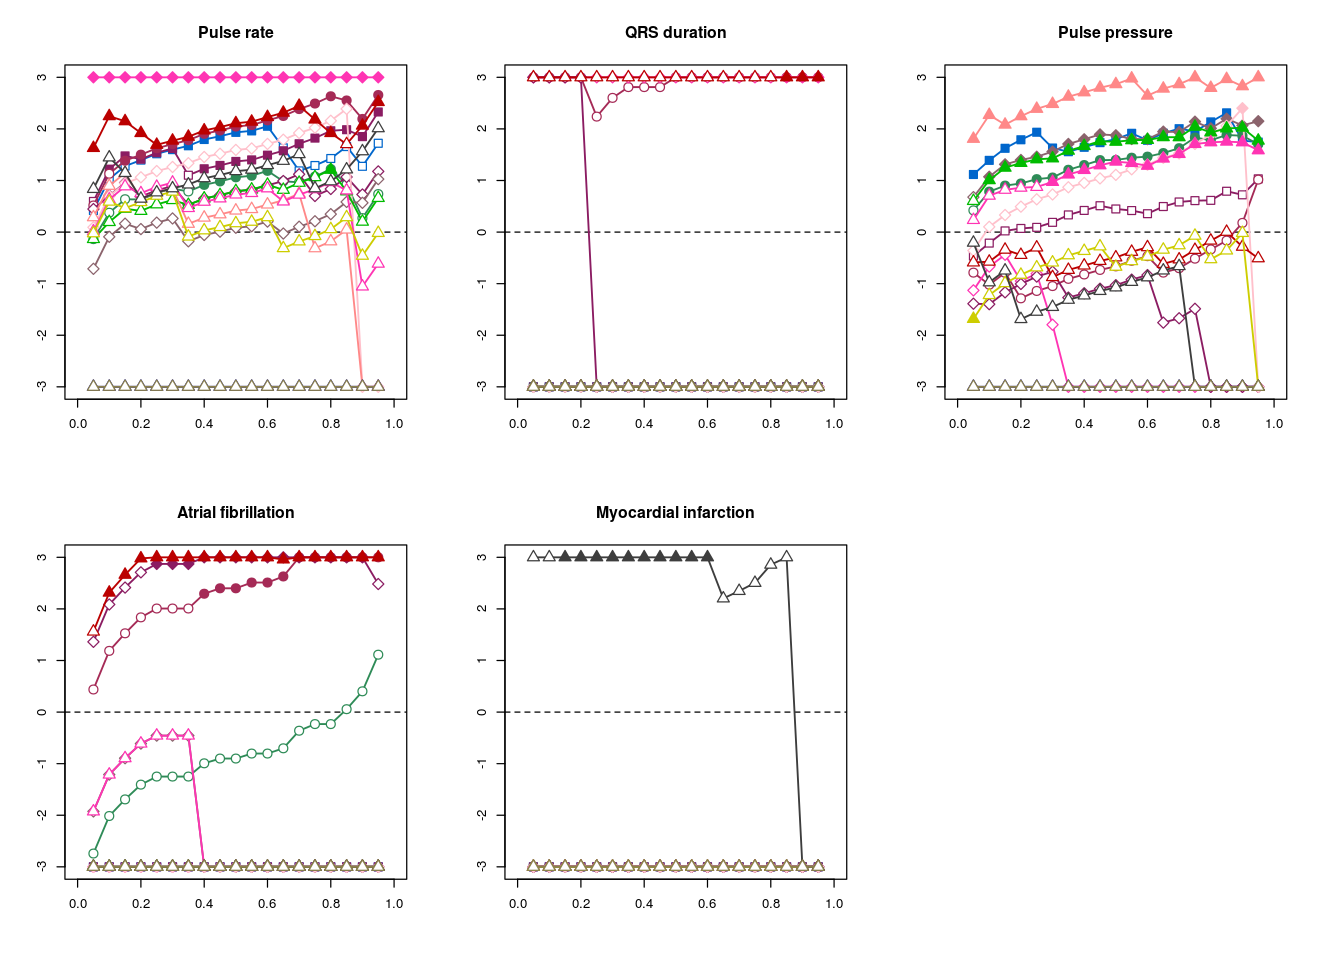

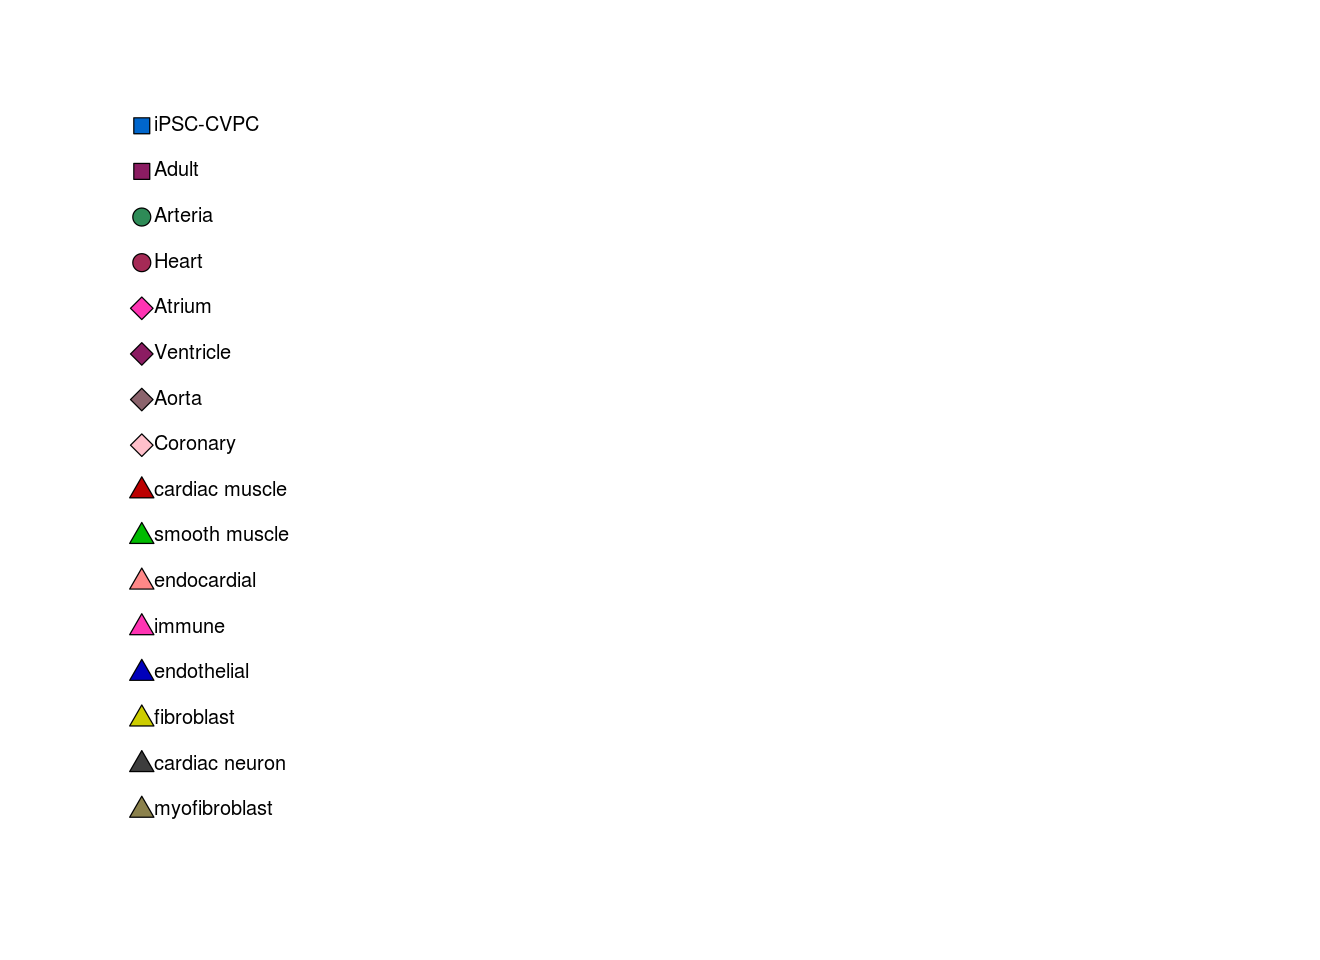

In [27]:
plot_enrichment = function(trait, enr1, colordata)
{
    x = enr1[ enr1$trait == trait, ]
    
    if(nrow(x[ x$log2r >=  3, ]) > 0){x[ x$log2r >=  3, "log2r"] =  3}
    if(nrow(x[ x$log2r <= -3, ]) > 0){x[ x$log2r <= -3, "log2r"] = -3}
    
    plot(1,1, type = "n", xlim = c(0,1), ylim = range(x$log2r), xlab = "", ylab = "", main = manifest[trait, "name"])
    
    abline(h = 0, lty = "dashed")
    
    for (cell in colordata$body_site)
    {
        toplot = x[ x$cell == cell,]
        color  = colordata[ colordata$body_site == cell, "color"]
        pch    = colordata[ colordata$body_site == cell, "pch"  ]
        toplot$bg = "#ffffff"
        
        if(nrow(toplot[toplot$pval <= 0.05,]) > 0){toplot[toplot$pval <= 0.05, "bg"] = color}
        
        lines (x = toplot$threshold, y = toplot$log2r, col = color, lwd =  1.5)
        points(x = toplot$threshold, y = toplot$log2r, col = color, pch = pch, bg = toplot$bg, cex = 1.5)
    }
}

trait = "continuous-PP-both_sexes-combined_medadj_irnt"

options(repr.plot.width = 11, repr.plot.height = 8)

layout(matrix(1:6, nrow = 2, byrow = TRUE))

invisible(lapply(manifest$id, function(trait){plot_enrichment(trait, enr1, colordata)}))

layout(1)
plot(1,1, type = "n", xlim = c(0,1), ylim = c(nrow(colordata), 1), xlab = "", ylab = "", axes = FALSE)

points(x = rep(0, nrow(colordata)), y = colordata$y, pch    = colordata$pch   , bg  = colordata$color, cex = 2)
text  (x = rep(0, nrow(colordata)), y = colordata$y, labels = colordata$tissue, pos = 4)



# Run coloc for fine mapping

In [28]:
get_gwas_data = function(coord, gwas_file)
{
    my_head              = colnames(fread(cmd = paste("zcat", gwas_file, "|", "head -n 2"), sep = "\t", header = TRUE, data.table = FALSE))
    gwas_data            = suppressWarnings(tabix.read.table(gwas_file, coord, col.names = TRUE, stringsAsFactors = FALSE))
    colnames(gwas_data)  = my_head
    gwas_data$variant_id = paste(gwas_data$chr, gwas_data$pos, gwas_data$ref, gwas_data$alt, sep = "_")
    rownames(gwas_data)  = gwas_data$variant_id
    
    return(gwas_data)
}

quiet = function(x) 
{ 
    sink(tempfile()) 
    on.exit(sink()) 
    invisible(force(x)) 
} 

create_dataset = function(study, trait_type, totest, variants, pop, populations, manifest)
{
    if(trait_type %in% c("categorical", "icd10", "phecode"))
    {
        if(pop == "meta"){n = sum(manifest[study, paste("n_cases", populations, sep = "_")]) + sum(manifest[study, paste("n_controls", populations, sep = "_")])}
        if(pop != "meta"){n =     manifest[study, paste("n_cases", pop        , sep = "_")]  +     manifest[study, paste("n_controls", pop        , sep = "_")] }
        
        if(pop == "meta"){s = sum(manifest[study, paste("n_cases", populations, sep = "_")]) / n}
        if(pop != "meta"){s =     manifest[study, paste("n_cases", pop        , sep = "_")]  / n}
        
        totest  = totest[is.na(totest[,paste("pval", pop, sep = "_")]) == FALSE & is.na(totest[,paste("af_controls", pop, sep = "_")]) == FALSE, ]
        dataset = list(snp = variants, pvalues = totest[variants, paste("pval", pop, sep = "_")], N = n, s = s, MAF = totest[variants, paste("af_controls", pop, sep = "_")], type = "cc")
    }
    if(trait_type %in% c("biomarkers", "continuous"))
    {
        if(pop == "meta"){n = sum(manifest[study, paste("n_cases", populations, sep = "_")])}
        if(pop != "meta"){n =     manifest[study, paste("n_cases", pop        , sep = "_")] }
        
        totest  = totest[is.na(totest[,paste("pval", pop, sep = "_")]) == FALSE & is.na(totest[,paste("af", pop, sep = "_")]) == FALSE, ]
        dataset = list(snp = variants, pvalues = totest[variants, paste("pval", pop, sep = "_")], N = n, MAF = totest[variants, paste("af", pop, sep = "_")], type = "quant")
    }
    if(trait_type == "qtl")
    {
        rownames(totest) = totest$id
        phenotype2n      = data.frame(phenotype = c("atac", "chip", "rna", "isoform"), n = c(259,131,966,966))
        dataset = list(snp     = variants, 
                       pvalues = totest     [variants, "pval"], 
                       N       = phenotype2n[phenotype2n$phenotype == pop, "n"], 
                       MAF     = totest     [variants, "af"], 
                       type    = "quant")
    }
    return(dataset)
}


finemap_coloc = function(ii, tofm)
{
    message(ii, appendLF = FALSE)
    #if(ii %in% trunc((0:100 / 100) * nrow(tofm))){print("." )}
    #if(ii %in% trunc((1: 10 /  10) * nrow(tofm))){print("\n")}
    
    transcript_id    = tofm[ii, "transcript_id"]
    phenotype        = tofm[ii, "phenotype"    ]
    type             = tofm[ii, "type"         ]
    trait            = tofm[ii, "gwas"         ]
    genes            = coordinates[ coordinates$transcript_id == transcript_id,]
    chrom            = sub("chr", "", genes[1, "chrom"])
    from             = max(c(0      , genes[1, "start"] - 500000))
    to               =                genes[1, "end"  ] + 500000
    coord            = paste0(chrom, ":", from, "-", to)
    gwas             = get_gwas_data(coord, manifest[trait, "sumstat_file"])
    
    if(phenotype == "rna"    ){toread = "gene"   }
    if(phenotype == "isoform"){toread = "isoform"}
    
    qtl              = fread(paste0("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtls_by_gene/cardiac_eqtls.", toread, "/qtl.", transcript_id, ".txt"), sep = "\t", header = TRUE, data.table = FALSE)
    qtl              = qtl[ qtl$type == type,]
    gwas$variant_id  = paste("VAR", gwas$variant_id, sep = "_")
    rownames(gwas)   = gwas$variant_id
    rownames(qtl )   = qtl $id
    variants         = intersect(gwas$variant_id, qtl$id)
    trait_type1      = manifest[trait, "trait_type"]
    trait_type2      = "qtl"
    totest1          = gwas
    totest2          = qtl
    pop              = "meta"
    populations      = unlist(strsplit(manifest[trait, "pops"], ","))
    
    if( trait_type1 %in% c("categorical", "icd10", "phecode")){variants1 = totest1[is.na(totest1[,paste("pval", pop, sep = "_")]) == FALSE & is.na(totest1[,paste("af_controls", pop, sep = "_")]) == FALSE, "id"]}
    if( trait_type1 %in% c("biomarkers", "continuous"       )){variants1 = totest1[is.na(totest1[,paste("pval", pop, sep = "_")]) == FALSE & is.na(totest1[,paste("af"         , pop, sep = "_")]) == FALSE, "id"]}

    dataset1        = create_dataset(trait        , trait_type1, totest1, variants, "meta"   , populations, manifest)
    dataset2        = create_dataset(transcript_id, trait_type2, totest2, variants, phenotype, c()        , manifest)
    coloc_mapped    = quiet(coloc.abf(dataset1 = dataset1, dataset2 = dataset2))
    out             = data.frame(id = coloc_mapped$results$snp,
                                 pp = coloc_mapped$results$SNP.PP.H4
                                )
    
    gwas_out           = gwas[,c("pos", "variant_id", "beta_meta", "se_meta", "pval_meta")]
    colnames(gwas_out) = c("pos", "id", "beta", "se", "pval")
    qtl$type           = NULL
    qtl$gene_id        = NULL
    out$pos            = as.numeric(unlist(lapply(out$id, function(x){unlist(strsplit(x, "_"))[[3]]})))
    out                = out[order(out$pp, decreasing = TRUE),]
    out                = out[order(out$pp, decreasing = TRUE), ]
    out$cum            = cumsum(out$pp)
    out$cs             = FALSE
    to_cs              = out[out$cum >= 0.99, ][1, "id"]
    
    out[out$cum < 0.99 | out$id == to_cs, "cs"] = TRUE

    credible_set = out[ out$cs == TRUE, "id"]
    
    
    out_list = list(transcript_id    = transcript_id,
                    phenotype        = phenotype    ,
                    type             = type         ,
                    trait            = trait        ,
                    coord            = coord        ,
                    gwas             = gwas_out     ,
                    qtl              = qtl          ,
                    finemap          = out          ,
                    credible_set     = credible_set ,
                    credible_set_n   = length(credible_set)
                   )
    return(out_list)
}

tofm           = pph4
fm_list        = lapply(1:nrow(tofm), function(ii){finemap_coloc(ii, tofm)})
names(fm_list) = paste(tofm$transcript_id, tofm$type, tofm$gwas, sep = ":")
saveRDS(fm_list, "pipeline/eqtls.0.1.coloc_gwas/fm_list.rds")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


# Find how many independent colocalized signals

In [29]:
eqtl_coloc = list(isoform         = fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.isoform.txt"      , sep = "\t", header = TRUE, data.table = FALSE),
                  gene            = fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.gene.txt"         , sep = "\t", header = TRUE, data.table = FALSE),
                  isoform_vs_gene = fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.coloc_by_gene.txt", sep = "\t", header = TRUE, data.table = FALSE)
                 )


In [30]:
pairs = unique(rbind(eqtl_coloc$isoform        [, c("transcript_id1", "transcript_id2", "type1", "type2", "PP.H4.abf")],
                     eqtl_coloc$gene           [, c("transcript_id1", "transcript_id2", "type1", "type2", "PP.H4.abf")],
                     eqtl_coloc$isoform_vs_gene[, c("transcript_id1", "transcript_id2", "type1", "type2", "PP.H4.abf")]
                    ))

pairs = merge(pairs, coordinates[,c("transcript_id", "gene_id", "gene_name")], by.x = "transcript_id1", by.y = "transcript_id")
pairs = merge(pairs, coordinates[,c("transcript_id", "gene_id", "gene_name")], by.x = "transcript_id2", by.y = "transcript_id", suffixes = 1:2)
pairs = aggregate(PP.H4.abf ~ transcript_id1 + gene_id1 + gene_name1 + type1 + transcript_id2 + gene_id2 + gene_name2 + type2, data = pairs[ pairs$gene_id1 != pairs$gene_id2,], FUN = max)
pairs = pairs[ pairs$transcript_id1 %in% pph4$transcript_id | pairs$transcript_id2 %in% pph4$transcript_id,]

In [31]:
pph4_merge1           = pph4[,c("transcript_id", "type", "gwas", "PP.H4.abf", "id", "pp_snp")]
pph4_merge2           = pph4[,c("transcript_id", "type", "gwas", "PP.H4.abf", "id", "pp_snp")]
colnames(pph4_merge1) = paste0(colnames(pph4_merge1), 1)
colnames(pph4_merge2) = paste0(colnames(pph4_merge2), 2)
pairs2gwas            = merge(pairs     , pph4_merge1, by = c("transcript_id1", "type1"), all.x = TRUE)
pairs2gwas            = merge(pairs2gwas, pph4_merge2, by = c("transcript_id2", "type2"), all.x = TRUE)

fwrite(pairs2gwas, "pipeline/eqtls.0.1.coloc_gwas/pairs2gwas.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

## LD for all lead vars in each chromosome and each GWAS

In [32]:
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(LDlinkR))


In [33]:
token = "44c6c4744e3e"

In [34]:
ids    = sort(unique(pph4$id))
snp2ld = as.data.frame(rbindlist(lapply(ids, function(id)
{
    gene_id = pph4[ pph4$id == id, "gene_id"][[1]]
    gtinfo  = fread(paste("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/1.3.genotype/tpm_gene/gt_info", gene_id, "txt", sep = "."), sep = "\t", header = TRUE, data.table = FALSE)
    
    return(gtinfo[gtinfo$id == id,])
})), stringsAsFactors = FALSE)


snp2ld$coord = paste0("chr", snp2ld$chrom, ":", snp2ld$pos)


In [35]:
mychroms = sort(unique(snp2ld$chrom))

ldmat_list = lapply(mychroms, function(chrom)
{
    message(chrom, appendLF = FALSE)
    out = list(r2 = suppressMessages(add_rownames(LDmatrix(snp2ld[ snp2ld$chrom == chrom, "coord"], pop = "ALL", r2d = "r2", token = token, file = FALSE))),
               d  = suppressMessages(add_rownames(LDmatrix(snp2ld[ snp2ld$chrom == chrom, "coord"], pop = "ALL", r2d = "d" , token = token, file = FALSE)))
              )
    
    return(out)
})

names(ldmat_list) = paste0("chr", mychroms)

saveRDS(ldmat_list, "pipeline/eqtls.0.1.coloc_gwas/ldmat_list.rds")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
22


In [36]:
signals = as.data.frame(rbindlist(lapply(mychroms, function(chrom)
{
    ldr = ldmat_list[[paste0("chr", chrom)]][["r2"]]
    ldd = ldmat_list[[paste0("chr", chrom)]][["d" ]]

    ldd = as.matrix(ldd)
    ldd[ ldd >= 0.9] = 1
    ldd[ ldd <  0.9] = 0

    clusters = clusters(graph_from_adjacency_matrix(ldd, mode = "upper", diag = FALSE))
    clusters = data.frame(rsid = names(clusters[["membership"]]), cluster = paste(chrom, as.numeric(clusters[["membership"]]), sep = "_"))
    clusters = merge(snp2ld[ snp2ld$chrom == chrom,], clusters, all.x = TRUE)
    out      = merge(pph4, clusters[,c("id", "rsid", "cluster")])
    
    if(nrow(out[ is.na(out$cluster) == TRUE, ]) > 0){out[ is.na(out$cluster) == TRUE, "cluster"] = paste(chrom, clusters[["no"]] + 1: nrow(out[ is.na(out$cluster) == TRUE, ]), sep = "_")}

    return(out)
})), stringsAsFactors = FALSE)

signals$cs = unlist(lapply(1:nrow(signals), function(ii){fm_list[[paste(signals[ii, "transcript_id"], signals[ii, "type"], signals[ii, "gwas"], sep = ":")]][["credible_set_n"]]}))



# clean fine mapping: only the eQTL with the smallest credible set and the highest PPA is kept

In [37]:
gwas2signal = unique(signals[,c("cluster","gwas")])
signals2fm  = as.data.frame(rbindlist(lapply(1: nrow(gwas2signal), function(ii)
{
    cluster   = gwas2signal[ii, "cluster"]
    trait     = gwas2signal[ii, "gwas"   ]
    indata    = signals    [ signals$gwas == trait & signals$cluster == cluster,]
    indata$fm = FALSE
    
    if(nrow(indata) > 1)
    {
        indata = indata[order(indata$cs, -indata$PP.H4.abf, -indata$pp_snp), ]
        indata[1,"fm"] = TRUE
    }else
    {
        indata$fm = TRUE
    }
    return(indata)
    #return(fm_list[[paste(indata[1, "transcript_id"], indata[1, "type"], indata[1, "gwas"], sep = ":")]][["credible_set_n"]])
})), stringsAsFactors = FALSE)

fwrite(signals2fm, "pipeline/eqtls.0.1.coloc_gwas/gwas_signals.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

In [38]:
sum(signals2fm$fm)


[1] 210

In [39]:
tofm                 = signals2fm[ signals2fm$fm == TRUE,]
finemap_clean        = lapply(1:nrow(tofm), function(ii){fm_list[[paste(tofm[ii, "transcript_id"], tofm[ii, "type"], tofm[ii, "gwas"], sep = ":")]]})
names(finemap_clean) = paste(tofm$transcript_id, tofm$type, tofm$gwas, sep = ":")
saveRDS(finemap_clean, "pipeline/eqtls.0.1.coloc_gwas/finemap_clean_list.rds")


In [40]:
cs2bin           = data.frame(bin  = 1:7, 
                              from = c(0, 1,  5, 10, 20,  50,   100), 
                              to   = c(1, 5, 10, 20, 50, 100, 10000))
cs2bin$name      = paste(cs2bin$from + 1, cs2bin$to, sep = "-")
cs2bin[1,"name"] = "1"
cs2bin[7,"name"] = "101+"

pp2bin           = data.frame(bin  = 1:8, 
                              from = c( 99, 95, 90, 80, 50, 10,  1, 0), 
                              to   = c(100, 99, 95, 90, 80, 50, 10, 1))
pp2bin$name      = paste(pp2bin$from, pp2bin$to, sep = "-")
pp2bin           = pp2bin[ rev(pp2bin$bin),]

fmdata           = merge(unique(coordinates[,c("gene_id", "gene_name")]), tofm[, c("transcript_id", "gene_id", "phenotype", "type", "gwas", "id", "rsid", "cs", "pp_snp")])
fmdata$csbin     = as.character(cut(fmdata$cs    , breaks = c(cs2bin$from, cs2bin[nrow(cs2bin), "to"])      , labels = cs2bin$name))
fmdata$ppbin     = as.character(cut(fmdata$pp_snp, breaks = c(pp2bin$from, pp2bin[nrow(pp2bin), "to"]) / 100, labels = pp2bin$name))

cs2bin_table     = table(fmdata$csbin)
pp2bin_table     = table(fmdata$ppbin)
cs2bin_table     = data.frame(name = names(cs2bin_table), n = as.numeric(cs2bin_table))
pp2bin_table     = data.frame(name = names(pp2bin_table), n = as.numeric(pp2bin_table))

cs2bin           = merge(cs2bin, cs2bin_table)
pp2bin           = merge(pp2bin, pp2bin_table)
cs2bin           = cs2bin[order(cs2bin$bin),]
pp2bin           = pp2bin[order(pp2bin$bin),]

cs2bin$per       = cs2bin$n / sum(cs2bin$n)
pp2bin$per       = pp2bin$n / sum(pp2bin$n)

fm_report = list(data = fmdata, cs2bin = cs2bin, pp2bin = pp2bin)

saveRDS(fm_report, "pipeline/eqtls.0.1.coloc_gwas/fm_report.rds")


# Overlap with GWAS catalog

In [41]:
catalog_start           = fread("/frazer01/reference/public/gwas_catalog/alternative.1", sep = "\t", header = TRUE, data.table = FALSE, quote = "")
catalog_start           = catalog_start[, c("SNPS", "PUBMEDID", "STUDY", "MAPPED_TRAIT", "CHR_ID", "P-VALUE", "PVALUE_MLOG", "OR or BETA", "95% CI (TEXT)")]
colnames(catalog_start) = c("rsid", "pmid", "study", "trait", "chrom", "pval", "logp", "beta", "confint")
catalog_start$pval      = as.numeric(catalog_start$pval)
catalog                 = catalog_start[ catalog_start$rsid %in% signals2fm$rsid, ]


In [42]:
catalog_start$name = ""
catalog_start[ grepl("heart rate"    , catalog_start$trait), "name"] = "Pulse rate"
catalog_start[ grepl("QRS"           , catalog_start$trait), "name"] = "QRS duration"
catalog_start[ grepl("pulse pressure", catalog_start$trait), "name"] = "Pulse pressure"
catalog_start[ grepl("blood pressure", catalog_start$trait), "name"] = "Pulse pressure"
catalog_start[ grepl("fibrillation"  , catalog_start$trait), "name"] = "Atrial fibrillation"
catalog_start[ grepl("myocardial"    , catalog_start$trait), "name"] = "Myocardial infarction"

catalog2trait       = catalog_start[ catalog_start$name != "",]
catalog2trait$chrom = unlist(lapply(catalog2trait$chrom, function(x)
{
    if(grepl(";", x) == TRUE)
    {
        x = unlist(strsplit(x, ";"))[[1]]
    }
    if(grepl(" ", x) == TRUE)
    {
        x = unlist(strsplit(x, " "))[[1]]
    }
    return(x)
}))

catalog2trait       = catalog2trait[ catalog2trait$chrom %in% as.character(1:22),]
catalog2trait$chrom = paste0("chr", catalog2trait$chrom)

In [43]:
x = data.frame(name = manifest$name, n = unlist(lapply(manifest$name, function(x){length(unique(catalog2trait[ catalog2trait$name == x, "rsid"]))})))

x
length(unique(catalog2trait$rsid))

name,n
<chr>,<int>
Pulse rate,519
QRS duration,196
Pulse pressure,3498
Atrial fibrillation,377
Myocardial infarction,270


[1] 4772

In [44]:
told = merge(unique(coordinates[,c("gene_id", "chrom"),]), signals2fm[ signals2fm$fm == TRUE,])
told = unique(rbind(told[,c("rsid", "chrom")], catalog2trait[,c("rsid", "chrom")]))


In [45]:
token = "44c6c4744e3e"

In [46]:
mychroms = sort(unique(told$chrom))

ldmat_list = lapply(mychroms, function(chrom)
{
    message(chrom, appendLF = FALSE)
    out = list(r2 = suppressMessages(add_rownames(LDmatrix(told[ told$chrom == chrom, "rsid"], pop = "ALL", r2d = "r2", token = token, file = FALSE))),
               d  = suppressMessages(add_rownames(LDmatrix(told[ told$chrom == chrom, "rsid"], pop = "ALL", r2d = "d" , token = token, file = FALSE)))
              )
    
    return(out)
})

names(ldmat_list) = mychroms

saveRDS(ldmat_list, "pipeline/eqtls.0.1.coloc_gwas/ldmat_catalog_list.rds")

chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr20
chr21
chr22
chr3
chr4
chr5
chr6
chr7
chr8
chr9


## Get coordinates of SNPs from RS ID

In [47]:
liftover         = "/software/ucsc.linux.x86_64.20151103/liftOver"
liftover_chain   = paste(getwd(), "input/hg38ToHg19.over.chain"                         , sep = "/")
catalog_bed_hg38 = paste(getwd(), "pipeline/eqtl.4.finemap_single/gwas_catalog_hg38.bed", sep = "/")
catalog_bed_hg19 = paste(getwd(), "pipeline/eqtl.4.finemap_single/gwas_catalog_hg19.bed", sep = "/")
tolift           = fread("pipeline/eqtl.4.finemap_single/gwas_catalog.bed", sep = "\t", header = FALSE, data.table = FALSE)
tolift[,4]       = gsub(" ", "", tolift[,4])
tolift[,2]       = tolift[,2] - 1

fwrite(unique(tolift), catalog_bed_hg38, sep = "\t", col.names = FALSE, row.names = FALSE)

command = paste(liftover, catalog_bed_hg38, liftover_chain, catalog_bed_hg19, "unMapped")

message(command)

/software/ucsc.linux.x86_64.20151103/liftOver /frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc/pipeline/eqtl.4.finemap_single/gwas_catalog_hg38.bed /frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc/input/hg38ToHg19.over.chain /frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc/pipeline/eqtl.4.finemap_single/gwas_catalog_hg19.bed unMapped



In [48]:
rs2coord           = fread(catalog_bed_hg19, sep = "\t", header = FALSE, data.table = FALSE)[,c(1,3,4)]
colnames(rs2coord) = c("chrom", "pos", "rsid")
rs2coord           = as.data.frame(rbindlist(lapply(1:nrow(rs2coord), function(ii)
{
    rsid = unlist(strsplit(rs2coord[ii, "rsid"], ";"))
    
    if(length(rsid) == 1){out = rs2coord[ii,]}
    if(length(rsid) >  1){out = data.frame(chrom = rs2coord[ii, "chrom"], pos = rs2coord[ii, "pos"], rsid = rsid)}
    
    return(out)
})), stringsAsFactors = FALSE)

rs2coord = unique(rs2coord)

In [49]:
fwrite(rs2coord, "pipeline/eqtl.4.finemap_single/gwas_catalog_hg19.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

## Output LD

In [50]:
get_ld_out = function(ii, fm2cat, ldmat_list, catalog2trait)
{
    rsid   = fm2cat[ ii, "rsid" ]
    chrom  = fm2cat[ ii, "chrom"]
    from   = fm2cat[ ii, "start"]
    to     = fm2cat[ ii, "end"  ]
    trait  = fm2cat[ ii, "gwas" ]
    id     = fm2cat[ ii, "id"   ]
    ids    = catalog2trait[ catalog2trait$chrom == chrom & catalog2trait$name == manifest[trait, "name"], "rsid"]
    #message(paste(ii, rsid))
    
    mypos = as.numeric(unlist(strsplit(id, "_"))[[2]])
    
    if(rsid %in% ids)
    {
        out1     = data.frame(overlap    = rsid, pos_catalog    = mypos, r2    = 1, d    = 1)
        out2     = data.frame(overlap_in = rsid, pos_catalog_in = mypos, r2_in = 1, d_in = 1)
    }else
    {
        told    = ldmat_list[[chrom]]
        told_r  = told[["r2"]]
        told_d  = told[["d" ]]
        myld    = data.frame(rsid = ids, r2 = told_r[ ids, rsid], d = told_d[ ids, rsid])
        myld    = merge(myld, rs2coord)
        myld    = myld[order(abs(myld$d), myld$r2, decreasing = TRUE),]
        myld_in = myld[myld$pos >= from - 1e6 & myld$pos <= to + 1e6,]
        out1    = data.frame(overlap    = myld   [1, "rsid"], pos_catalog    = myld   [1, "pos"], r2    = myld   [1, "r2"], d    = myld   [1, "d"])
        
        if(nrow(myld_in) >  0){out2 = data.frame(overlap_in = myld_in[1, "rsid"], pos_catalog_in = myld_in[1, "pos"], r2_in = myld_in[1, "r2"], d_in = myld_in[1, "d"])}
        if(nrow(myld_in) == 0){out2 = data.frame(overlap_in = ""                , pos_catalog_in = 0                , r2_in = 0               , d_in = 0)}
    }
    
    out      = cbind(out1, out2)
    out$pmid = paste(sort(unique(catalog2trait[ catalog2trait$rsid == out[1, "overlap"] & catalog2trait$name == manifest[trait, "name"], "pmid"])), collapse = ";")
    
    return(out)
}


fm2cat = merge(unique(coordinates[ coordinates$phenotype == "rna",c("gene_id", "gene_name", "chrom", "start", "end"),]), signals2fm[ signals2fm$fm == TRUE,])

#get_ld_out(210, fm2cat, ldmat_list, catalog2trait)
#get_ld_out("rs17881696", fm2cat, ldmat_list, catalog2trait)

fm2cat       = cbind(fm2cat, as.data.frame(rbindlist(lapply(1:nrow(fm2cat), function(ii){get_ld_out(ii, fm2cat, ldmat_list, catalog2trait)}))), stringsAsFactors = FALSE)
fm2cat$pos   = as.numeric(unlist(lapply(fm2cat$id, function(x){unlist(strsplit(x, "_"))[[3]]})))
fm2cat$cat   = ""

fm2cat[ fm2cat$rsid == fm2cat$overlap, "cat"] = "in catalog"
fm2cat[ fm2cat$rsid != fm2cat$overlap & abs(fm2cat$d ) >= 0.8                                      , "cat"] = "high D'"
fm2cat[ fm2cat$rsid != fm2cat$overlap & abs(fm2cat$d ) >= 0.8 & fm2cat$overlap == fm2cat$overlap_in, "cat"] = "high D' IN"
fm2cat[ fm2cat$rsid != fm2cat$overlap &     fm2cat$r2  >= 0.8                                      , "cat"] = "high R2"

fm2cat[,grepl("^interaction", colnames(fm2cat)) == TRUE] = NULL

fwrite(fm2cat, "pipeline/eqtls.0.1.coloc_gwas/fm2cat.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [51]:
table(fm2cat$cat)


              high D' high D' IN    high R2 in catalog 
        53         66         35         13         43 

# Test
- Hypothesis: fine mapped SNP is more rare, has a stronger effect size and is more likely to be functional than the SNP in high D'. But they both point to the same signal

In [57]:
totest     = fm2cat[ fm2cat$cat %in% c("high D'", "high D' IN"),]
snps       = rbind(data.frame(gwas = totest$gwas, id = totest$id, rsid = totest$rsid      , chrom = totest$chrom, pos = totest$pos           ),
                   data.frame(gwas = totest$gwas, id = totest$id, rsid = totest$overlap   , chrom = totest$chrom, pos = totest$pos_catalog   ),
                   data.frame(gwas = totest$gwas, id = totest$id, rsid = totest$overlap_in, chrom = totest$chrom, pos = totest$pos_catalog_in)
                  )
snps       = unique(snps[ snps$rsid != "",])
snps$coord = paste0(sub("chr", "", snps$chrom), ":", snps$pos - 10, "-", snps$pos + 10)

In [105]:
get_gwas_data = function(coord, gwas_file)
{
    my_head              = colnames(fread(cmd = paste("zcat", gwas_file, "|", "head -n 2"), sep = "\t", header = TRUE, data.table = FALSE))
    gwas_data            = suppressWarnings(tabix.read.table(gwas_file, coord, col.names = TRUE, stringsAsFactors = FALSE))
    
    if(nrow(gwas_data) == 0)
    {
        gwas_data = data.frame(pos = 0, ref = "", alt = "", chr = 0, af_meta = 0, beta_meta = 0, se_meta = 0, pval_meta = 1)
    }else
    {
        colnames(gwas_data)  = my_head
        gwas_data$ref        = gsub("RUE", "", gwas_data$ref)
        gwas_data$alt        = gsub("RUE", "", gwas_data$alt)
    }
    
    gwas_data$id         = paste("VAR", gwas_data$chr, gwas_data$pos, gwas_data$ref, gwas_data$alt, sep = "_")
    rownames(gwas_data)  = gwas_data$id
    
    return(gwas_data)
}

get_effect = function(ii, snps, manifest)
{
    message(ii, appendLF = FALSE)
    trait          = snps[ii, "gwas" ]
    coord          = snps[ii, "coord"]
    pos            = snps[ii, "pos"  ]
    gwas           = get_gwas_data(coord, manifest[trait, "sumstat_file"])
    mycols         = colnames(gwas)[ colnames(gwas) %in% c("pos", paste(c("af", "af_controls", "beta", "se", "pval"), "meta", sep = "_"))]
    gwas           = gwas[ gwas$pos == pos, mycols]
    
    if(nrow(gwas) == 0){gwas = data.frame(pos = pos, af = 0, beta = 0, se = 0, pval = 1)}
    colnames(gwas) = c("pos", "af", "beta", "se", "pval")

    return(gwas)
}

#ii = 102
#x  = get_effect(ii, snps, manifest)
snp2gwas = cbind(snps, as.data.frame(rbindlist(lapply(1:nrow(snps), function(ii){get_effect(ii, snps, manifest)})), stringsAsFactors = FALSE))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109


ERROR: Error in names(x) <- value: 'names' attribute [39] must be the same length as the vector [38]


In [97]:
str(snp2gwas)

ERROR: Error in str(snp2gwas): object 'snp2gwas' not found


In [66]:
str(snps)

'data.frame':	257 obs. of  6 variables:
 $ gwas : chr  "icd10-I48-both_sexes" "continuous-PP-both_sexes-combined_medadj_irnt" "continuous-102-both_sexes-irnt" "icd10-I48-both_sexes" ...
 $ id   : chr  "VAR_2_65283972_T_C" "VAR_8_142232878_G_A" "VAR_5_137419989_C_T" "VAR_5_137370990_G_A" ...
 $ rsid : chr  "rs74181299" "rs4961258" "rs2040862" "rs77915370" ...
 $ chrom: chr  "chr2" "chr8" "chr5" "chr5" ...
 $ pos  : num  6.53e+07 1.42e+08 1.37e+08 1.37e+08 1.00e+08 ...
 $ coord: chr  "2:65283962-65283982" "8:142232868-142232888" "5:137419979-137419999" "5:137370980-137371000" ...


In [ ]:
str(manifest)